作業1：使用 LSTM 模型預測股票未來價格，自訂窗口大小，並分析預測效果。

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 設定股票代號與時間範圍
stock_id = '2330.TW'
end = dt.date.today()
start = end - dt.timedelta(days=1460)
df_stat = yf.download(stock_id, start=start, end=end)

# 新增移動平均線和其他技術指標
df_stat['SMA_5'] = df_stat['Close'].rolling(window=5).mean()
df_stat['SMA_20'] = df_stat['Close'].rolling(window=20).mean()
df_stat['EMA_10'] = df_stat['Close'].ewm(span=10, adjust=False).mean()
df_stat['RSI'] = 100 - (100 / (1 + df_stat['Close'].diff().gt(0).rolling(14).sum() / df_stat['Close'].diff().lt(0).rolling(14).sum()))
df_stat['MACD'] = df_stat['Close'].ewm(span=12, adjust=False).mean() - df_stat['Close'].ewm(span=26, adjust=False).mean()
df_stat['Volume'] = df_stat['Volume']


df_stat = df_stat.dropna()

# 設定特徵
features = df_stat[['Close', 'SMA_5', 'SMA_20', 'EMA_10', 'RSI', 'MACD', 'Volume']].values

# 定義窗口大小
N = 20

# 準備數據集，將每個樣本擴展為包含前 N 天的數據
def create_sequences(features, labels, N):
    X, y = [], []
    for i in range(N, len(features)):
        X.append(features[i-N:i])  # 前 N 天的特徵
        y.append(labels[i])        # 第 i 天的標籤
    return np.array(X), np.array(y)

# 使用特徵進行標準化
feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(features)

# 對標籤（收盤價）進行標準化
label_scaler = MinMaxScaler()
scaled_labels = label_scaler.fit_transform(df_stat['Close'].values.reshape(-1, 1))

# 構建序列數據
X, y = create_sequences(scaled_features, scaled_labels, N)

# 分割訓練和測試數據
train_size = int(len(X) * 0.7)
train_features, test_features = X[:train_size], X[train_size:]
train_labels, test_labels = y[:train_size], y[train_size:]

# 將數據轉換為 tensor 格式
train_features = torch.tensor(train_features, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32).squeeze()
test_features = torch.tensor(test_features, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32).squeeze()

# 檢查數據形狀
print("train_features shape:", train_features.shape)  # 應該是 (樣本數量, N, 特徵數量)
print("train_labels shape:", train_labels.shape)
print("test_features shape:", test_features.shape)
print("test_labels shape:", test_labels.shape)

[*********************100%***********************]  1 of 1 completed

train_features shape: torch.Size([653, 20, 7])
train_labels shape: torch.Size([653])
test_features shape: torch.Size([280, 20, 7])
test_labels shape: torch.Size([280])


輸入10天收盤價，預測隔一天收盤價

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0189 - val_loss: 0.0275
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.3096e-04 - val_loss: 0.0047
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8031e-04 - val_loss: 0.0025
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4675e-04 - val_loss: 0.0020
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5357e-04 - val_loss: 0.0020
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5382e-04 - val_loss: 0.0022
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5927e-04 - val_loss: 0.0024
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6306e-04 - val_loss: 0.0026
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6329e-04 - val_loss: 0.0027
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5987e-04 - val_loss: 0.0028
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5391e-04 - val_loss: 0.0029
Epoch 12/100
42/42 ━━

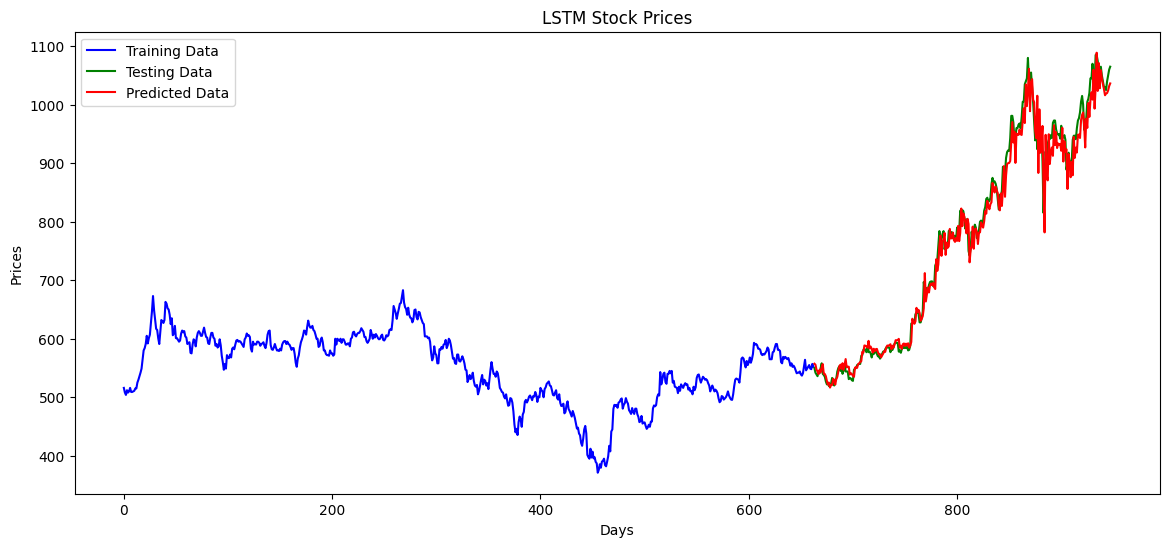

In [99]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# 建立 LSTM 模型
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
history = model.fit(train_features, train_labels, epochs=100, batch_size=16, validation_data=(test_features, test_labels), verbose=1)

# 預測
predictions = model.predict(test_features)

# 還原標準化的數據
predicted_prices = label_scaler.inverse_transform(predictions)
actual_prices = label_scaler.inverse_transform(test_labels.reshape(-1, 1))

# 計算 MSE 損失
mse = mean_squared_error(actual_prices, predicted_prices)
print(f"Test MSE: {mse:.4f}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 還原標準化的數據
train_prices = label_scaler.inverse_transform(train_labels.reshape(-1, 1))
test_prices = label_scaler.inverse_transform(test_labels.reshape(-1, 1))
predicted_prices = label_scaler.inverse_transform(predictions)

# 計算 MSE 損失
mse = mean_squared_error(test_prices, predicted_prices)
print(f"Test MSE: {mse:.4f}")

# 構建 x 軸的索引
train_index = np.arange(len(train_prices))
test_index = np.arange(len(train_prices), len(train_prices) + len(test_prices))

# 視覺化結果
plt.figure(figsize=(14, 6))
plt.plot(train_index, train_prices, color="blue", label="Training Data")          # 訓練數據
plt.plot(test_index, test_prices, color="green", label="Testing Data")             # 測試數據
plt.plot(test_index, predicted_prices, color="red", label="Predicted Data")        # 預測數據

# 標題和標籤
plt.title("LSTM Stock Prices")
plt.xlabel("Days")
plt.ylabel("Prices")
plt.legend()
plt.show()

預測結果區域

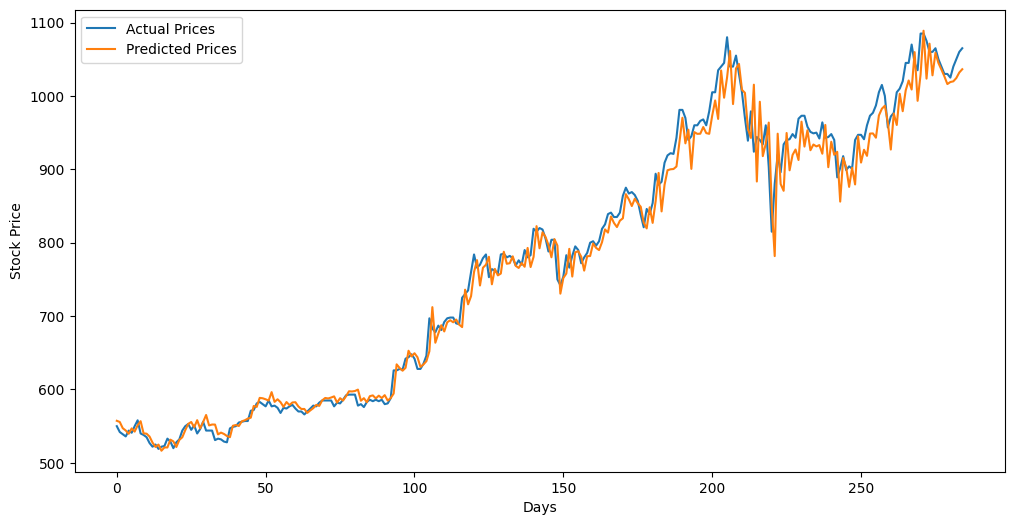

In [100]:
# 視覺化結果
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

作業2：使用 Transformer 模型預測股價漲跌，自訂窗口大小，並分析預測結果。

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 定義 transformer block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, attention_axes=None):
    """
    Creates a single transformer block.
    """
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

# 定義最終 Transformer 模型
def build_transformer_model(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units,
                            dropout=0, mlp_dropout=0):
    """
    Creates final model by building many transformer blocks.
    """
    n_timesteps = train_features.shape[1]
    n_features = train_features.shape[2]
    n_outputs = 1  # 預測單一輸出

    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs, activation='linear')(x)
    return tf.keras.Model(inputs, outputs)

輸入20天收盤價，預測隔一天收盤價

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0229 - val_loss: 0.1403
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0216 - val_loss: 0.1091
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0219 - val_loss: 0.0922
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0194 - val_loss: 0.0846
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0170 - val_loss: 0.0787
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0135 - val_loss: 0.0712
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0128 - val_loss: 0.0596
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0148 - val_loss: 0.0561
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0118 - val_loss: 0.0557
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0098 - val_loss: 0.0522
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0107 - val_loss: 0.0522
Epoch 12/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/ste

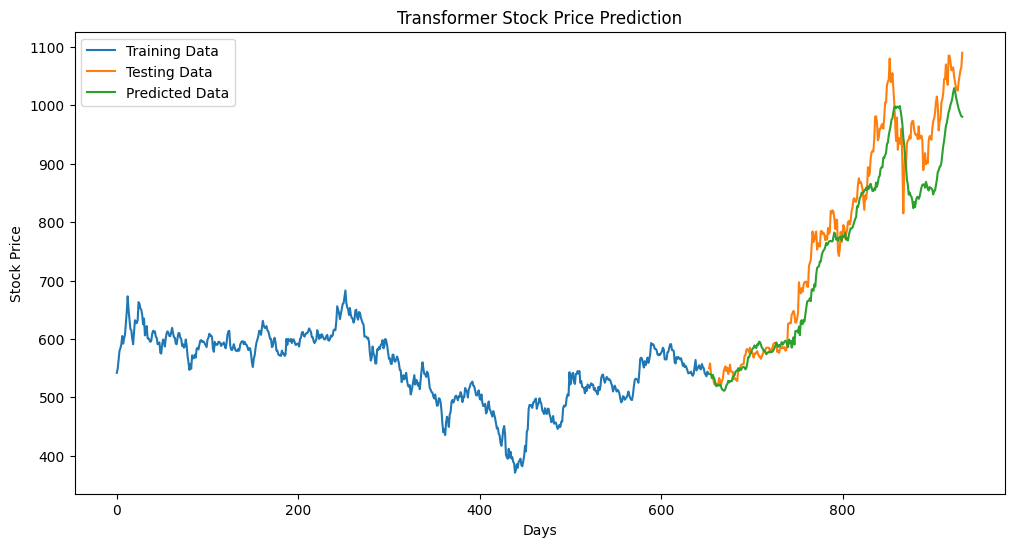

In [6]:
# 設定模型參數
head_size = 128
num_heads = 4
ff_dim = 64
num_trans_blocks = 4
mlp_units = [256]
dropout = 0.1
mlp_dropout = 0.1

# 建立模型
model = build_transformer_model(
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_trans_blocks=num_trans_blocks,
    mlp_units=mlp_units,
    dropout=dropout,
    mlp_dropout=mlp_dropout
)

# 編譯模型
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6)
)

# 定義訓練回調
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

# 模型訓練
history = model.fit(
    train_features, train_labels,
    batch_size=8,
    epochs=100,
    validation_data=(test_features, test_labels),
    verbose=1,
    callbacks=callbacks
)

# 預測
predictions = model.predict(test_features)

# 還原標準化的數據
predicted_prices = label_scaler.inverse_transform(predictions)
actual_prices = label_scaler.inverse_transform(test_labels.reshape(-1, 1))

# 計算 MSE
mse = mean_squared_error(actual_prices, predicted_prices)
print(f"Test MSE: {mse:.4f}")

# 視覺化結果
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_labels)), label_scaler.inverse_transform(train_labels.reshape(-1, 1)), label='Training Data')
plt.plot(range(len(train_labels), len(train_labels) + len(test_labels)), actual_prices, label='Testing Data')
plt.plot(range(len(train_labels), len(train_labels) + len(test_labels)), predicted_prices, label='Predicted Data')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.title("Transformer Stock Price Prediction")
plt.show()

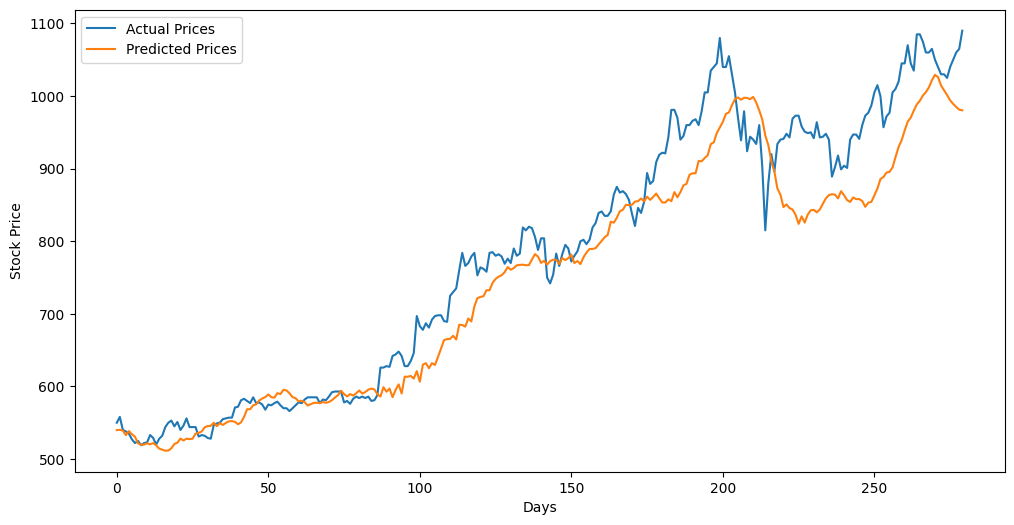

In [7]:
# 視覺化結果
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()